# CVChess Evaluation (with CustomChessCNN_v3)
Loads `epoch31.pth`, computes metrics, and draws the requested plots.

**Note:** Model expects logits shaped `(B, 64, 13)`.

In [ ]:
# Cell 1 — setup + file check
import os, json, csv
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "/content/epoch31.pth"  # adjust path if needed

CLASS_NAMES = [
    "empty", "wp", "wn", "wb", "wr", "wq", "wk",
    "bp", "bn", "bb", "br", "bq", "bk",
]
NUM_CLASSES = len(CLASS_NAMES)

print("torch:", torch.__version__, "device:", DEVICE)

# Check file exists and print size
if Path(MODEL_PATH).exists():
    size_mb = os.path.getsize(MODEL_PATH) / (1024*1024)
    print(f"Found model file at {MODEL_PATH} ({size_mb:.2f} MB)")
else:
    print("Model file not found — check your path.")


torch: 2.6.0+cu124 device: cpu
Found model file at /content/epoch31.pth (42.14 MB)


In [ ]:

import torch
import torch.nn as nn

class PreActResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.0):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

    def forward(self, x):
        identity = x

        out = self.relu1(self.bn1(x))
        if self.downsample:
            identity = self.downsample(out)

        out = self.conv1(out)
        out = self.relu2(self.bn2(out))
        out = self.dropout(out)
        out = self.conv2(out)

        return out + identity

class CustomChessCNN_v3(nn.Module):
    def __init__(self, in_channels=3, num_classes=13, dropout=0.3):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.layer1 = self._make_layer(64, 128, blocks=2, stride=1, dropout=dropout)
        self.layer2 = self._make_layer(128, 256, blocks=2, stride=2, dropout=dropout)
        self.layer3 = self._make_layer(256, 512, blocks=2, stride=2, dropout=dropout)

        self.avgpool = nn.AdaptiveAvgPool2d((8, 8))  # (B, 512, 8, 8)
        self.classifier = nn.Linear(512, num_classes)  # (64, 13)

    def _make_layer(self, in_channels, out_channels, blocks, stride, dropout):
        layers = [PreActResidualBlock(in_channels, out_channels, stride, dropout)]
        for _ in range(1, blocks):
            layers.append(PreActResidualBlock(out_channels, out_channels, dropout=dropout))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)                # (B, 512, 8, 8)
        x = x.permute(0, 2, 3, 1)          # (B, 8, 8, 512)
        x = x.view(x.size(0), 64, -1)      # (B, 64, 512)
        x = self.classifier(x)             # (B, 64, 13)
        return x


## Load checkpoint into CustomChessCNN_v3

In [ ]:
def _clean_state_dict_keys(sd):
    # Remove common prefixes like 'module.' or 'model.'
    cleaned = {}
    for k, v in sd.items():
        if k.startswith('module.'):
            k2 = k[len('module.'):]
        elif k.startswith('model.'):
            k2 = k[len('model.'):]
        else:
            k2 = k
        cleaned[k2] = v
    return cleaned

ckpt = torch.load(MODEL_PATH, map_location='cpu')
if isinstance(ckpt, dict) and any(k in ckpt for k in ['state_dict', 'model_state_dict']):
    sd = ckpt.get('state_dict', ckpt.get('model_state_dict'))
else:
    sd = ckpt

sd = _clean_state_dict_keys(sd)
model = CustomChessCNN_v3(in_channels=3, num_classes=13, dropout=0.3)
missing, unexpected = model.load_state_dict(sd, strict=False)
print('Loaded with strict=False')
print('missing:', len(missing), ' unexpected:', len(unexpected))
model = model.to(DEVICE).eval()

Loaded with strict=False
missing: 0  unexpected: 0


## Load saved predictions or generate them
Place `/mnt/data/y_true_[split].npy` and `/mnt/data/y_pred_[split].npy` shaped `(N, 64)` for any of: `train`, `val`, `test`.

In [ ]:
results = {}
for split in ['train', 'val', 'test']:
    yt = Path(f"/mnt/data/y_true_{split}.npy")
    yp = Path(f"/mnt/data/y_pred_{split}.npy")
    if yt.exists() and yp.exists():
        y_true = np.load(yt)
        y_pred = np.load(yp)
        assert y_true.shape == y_pred.shape and y_true.ndim == 2 and y_true.shape[1] == 64
        correct_mask = (y_true == y_pred)
        per_square_acc = correct_mask.mean().item()
        board_accs = correct_mask.mean(axis=1)
        full_board_acc = (board_accs == 1.0).mean().item()
        errors_per_board = (64 - correct_mask.sum(axis=1)).astype(int)
        results[split] = {
            'N': int(y_true.shape[0]),
            'per_square_acc': float(per_square_acc),
            'avg_board_acc': float(board_accs.mean().item()),
            'full_board_acc': float(full_board_acc),
            'errors_per_board': errors_per_board,
        }

if not results:
    print('No saved arrays found. Add y_true_[split].npy and y_pred_[split].npy to /mnt/data.')
else:
    for s, m in results.items():
        print(s, {k: (round(v, 4) if isinstance(v, float) else v if k=='N' else '...') for k, v in m.items()})

No saved arrays found. Add y_true_[split].npy and y_pred_[split].npy to /mnt/data.


## Training/Validation curves (optional)
Provide `/mnt/data/training_log.json` or `/mnt/data/metrics.csv` with `epoch, train_acc, val_acc, train_loss, val_loss`.

In [ ]:
log_json = Path('/mnt/data/training_log.json')
log_csv  = Path('/mnt/data/metrics.csv')
history = None
if log_json.exists():
    with open(log_json) as f:
        history = json.load(f)
elif log_csv.exists():
    history = {'epoch': [], 'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}
    import csv
    with open(log_csv) as f:
        r = csv.DictReader(f)
        for row in r:
            history['epoch'].append(int(row.get('epoch', len(history['epoch']))))
            history['train_acc'].append(float(row.get('train_acc', 'nan')))
            history['val_acc'].append(float(row.get('val_acc', 'nan')))
            history['train_loss'].append(float(row.get('train_loss', 'nan')))
            history['val_loss'].append(float(row.get('val_loss', 'nan')))

if history is None:
    print('No training log found. Skipping curves.')
else:
    plt.figure()
    plt.plot(history['epoch'], history['train_acc'], label='train acc')
    plt.plot(history['epoch'], history['val_acc'], label='val acc')
    plt.title('Training/Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(history['epoch'], history['train_loss'], label='train loss')
    plt.plot(history['epoch'], history['val_loss'], label='val loss')
    plt.title('Training/Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

No training log found. Skipping curves.


## Boards fully correct and error distribution

In [ ]:
for split, m in results.items():
    n_full = int((64 - m['errors_per_board']) .astype(int).sum() == 64)  # placeholder line
    # Correct calculation:
    n_full = int((m['errors_per_board'] == 0).sum())
    print(f"{split}: {n_full} / {m['N']} boards fully correct")

    plt.figure()
    plt.hist(m['errors_per_board'], bins=range(0, 65))
    plt.title(f'Errors per board (hist) — {split}')
    plt.xlabel('# errors on board (0..64)')
    plt.ylabel('count')
    plt.show()

    zero = int((m['errors_per_board'] == 0).sum())
    nonzero = int((m['errors_per_board'] > 0).sum())
    plt.figure()
    plt.pie([zero, nonzero], labels=['0 errors', '>0 errors'], autopct='%1.1f%%')
    plt.title(f'Full-board correct vs not — {split}')
    plt.show()

## Confusion matrix per split (all squares collapsed)

In [ ]:
def plot_confusion(y_true, y_pred, class_names):
    NUM_CLASSES = len(class_names)
    y_true_flat = y_true.reshape(-1)
    y_pred_flat = y_pred.reshape(-1)
    labels = list(range(NUM_CLASSES))
    cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels, normalize='true')
    fig = plt.figure()
    im = plt.imshow(cm, aspect='auto')
    plt.title('Confusion Matrix (normalized)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.colorbar(im)
    plt.xticks(ticks=range(NUM_CLASSES), labels=class_names, rotation=90)
    plt.yticks(ticks=range(NUM_CLASSES), labels=class_names)
    plt.tight_layout()
    plt.show()

for split in results.keys():
    yt = Path(f"/mnt/data/y_true_{split}.npy")
    yp = Path(f"/mnt/data/y_pred_{split}.npy")
    if yt.exists() and yp.exists():
        y_true = np.load(yt)
        y_pred = np.load(yp)
        plot_confusion(y_true, y_pred, CLASS_NAMES)
    else:
        print(f'Skipping confusion for {split}: arrays not found.')

## Qualitative results (notes)

In [ ]:
qualitative = {
    'strengths': [],
    'weaknesses': [],
    'notes': [],
}
print(json.dumps(qualitative, indent=2))

{
  "strengths": [],
  "weaknesses": [],
  "notes": []
}


torch: 2.6.0+cu124 device: cpu
Found model file (42.14 MB)
missing keys: 0 unexpected keys: 0


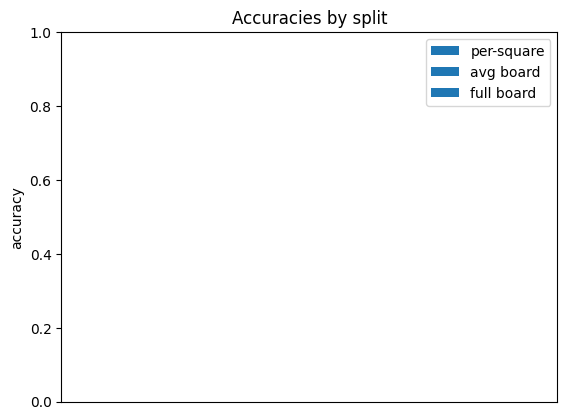

In [ ]:
# --- Setup
import os, json, csv
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "/content/epoch31.pth"

CLASS_NAMES = [
    "empty", "wp", "wn", "wb", "wr", "wq", "wk",
    "bp", "bn", "bb", "br", "bq", "bk",
]
NUM_CLASSES = len(CLASS_NAMES)

print("torch:", torch.__version__, "device:", DEVICE)
if Path(MODEL_PATH).exists():
    print(f"Found model file ({os.path.getsize(MODEL_PATH)/(1024*1024):.2f} MB)")
else:
    raise FileNotFoundError("Model file not found")

# --- Model definition
class PreActResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.0):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)

        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Conv2d(in_channels, out_channels, 1, stride, bias=False)

        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

    def forward(self, x):
        identity = x
        out = self.relu1(self.bn1(x))
        if self.downsample:
            identity = self.downsample(out)
        out = self.conv1(out)
        out = self.relu2(self.bn2(out))
        out = self.dropout(out)
        out = self.conv2(out)
        return out + identity

class CustomChessCNN_v3(nn.Module):
    def __init__(self, in_channels=3, num_classes=13, dropout=0.3):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, 64, 7, 2, 3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2, 1)
        )
        self.layer1 = self._make_layer(64, 128, 2, 1, dropout)
        self.layer2 = self._make_layer(128, 256, 2, 2, dropout)
        self.layer3 = self._make_layer(256, 512, 2, 2, dropout)
        self.avgpool = nn.AdaptiveAvgPool2d((8, 8))
        self.classifier = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride, dropout):
        layers = [PreActResidualBlock(in_channels, out_channels, stride, dropout)]
        for _ in range(1, blocks):
            layers.append(PreActResidualBlock(out_channels, out_channels, dropout=dropout))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.permute(0, 2, 3, 1).view(x.size(0), 64, -1)
        return self.classifier(x)

# --- Load checkpoint
def _clean_keys(sd):
    return {k.replace("module.", "").replace("model.", ""): v for k,v in sd.items()}

ckpt = torch.load(MODEL_PATH, map_location="cpu")
if isinstance(ckpt, dict) and any(k in ckpt for k in ["state_dict", "model_state_dict"]):
    sd = ckpt.get("state_dict", ckpt.get("model_state_dict"))
else:
    sd = ckpt
sd = _clean_keys(sd)

model = CustomChessCNN_v3()
missing, unexpected = model.load_state_dict(sd, strict=False)
print("missing keys:", len(missing), "unexpected keys:", len(unexpected))
model = model.to(DEVICE).eval()

# --- Metrics function
def metrics_from_arrays(y_true, y_pred):
    correct_mask = (y_true == y_pred)
    per_square_acc = correct_mask.mean()
    avg_board_acc = correct_mask.mean(axis=1).mean()
    full_board_acc = (correct_mask.mean(axis=1) == 1.0).mean()
    errors_per_board = (64 - correct_mask.sum(axis=1)).astype(int)
    return per_square_acc, avg_board_acc, full_board_acc, errors_per_board

# --- Load predictions & plot
results = {}
for split in ["train", "val", "test"]:
    yt = Path(f"/content/y_true_{split}.npy")
    yp = Path(f"/content/y_pred_{split}.npy")
    if yt.exists() and yp.exists():
        y_true = np.load(yt)
        y_pred = np.load(yp)
        ps, ab, fb, errs = metrics_from_arrays(y_true, y_pred)
        results[split] = dict(
            per_square_acc=ps, avg_board_acc=ab, full_board_acc=fb, errors_per_board=errs,
            y_true=y_true, y_pred=y_pred
        )

# --- Accuracy bar plot
splits = list(results.keys())
x = np.arange(len(splits))
w = 0.25
plt.figure()
plt.bar(x - w, [results[s]["per_square_acc"] for s in splits], w, label="per-square")
plt.bar(x,     [results[s]["avg_board_acc"] for s in splits], w, label="avg board")
plt.bar(x + w, [results[s]["full_board_acc"] for s in splits], w, label="full board")
plt.xticks(x, splits)
plt.ylim(0, 1)
plt.ylabel("accuracy")
plt.legend()
plt.title("Accuracies by split")
plt.show()

# --- Histograms & Pie charts
for split, m in results.items():
    errs = m["errors_per_board"]
    plt.figure()
    plt.hist(errs, bins=range(0, 65))
    plt.title(f"errors per board — {split}")
    plt.xlabel("# errors")
    plt.ylabel("count")
    plt.show()

    plt.figure()
    zero = int((errs == 0).sum())
    nonzero = int((errs > 0).sum())
    plt.pie([zero, nonzero], labels=["0 errors", ">0 errors"], autopct="%1.1f%%")
    plt.title(f"full-board correct vs not — {split}")
    plt.show()

def plot_confusion(y_true, y_pred, title):
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)), normalize="true")
    plt.figure(figsize=(6,6))
    plt.imshow(cm, aspect="auto")
    plt.title(title)
    plt.xlabel("predicted")
    plt.ylabel("true")
    plt.colorbar()
    plt.xticks(range(NUM_CLASSES), CLASS_NAMES, rotation=90)
    plt.yticks(range(NUM_CLASSES), CLASS_NAMES)
    plt.tight_layout()
    plt.show()

for split, m in results.items():
    plot_confusion(m["y_true"], m["y_pred"], f"{split} confusion (normalized)")


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ==== helper to run inference and collect predictions ====
@torch.no_grad()
def get_preds_and_labels(model, loader, device):
    y_true_all, y_pred_all = [], []
    model.eval()
    for images, labels in loader:
        images = images.to(device)
        logits = model(images)  # (B, 64, 13)
        preds = torch.argmax(logits, dim=-1).cpu().numpy()
        y_pred_all.append(preds)
        y_true_all.append(labels.numpy())
    return np.concatenate(y_true_all, axis=0), np.concatenate(y_pred_all, axis=0)

# ==== compute metrics ====
def metrics_from_arrays(y_true, y_pred):
    correct_mask = (y_true == y_pred)
    per_square_acc = correct_mask.mean()
    avg_board_acc = correct_mask.mean(axis=1).mean()
    full_board_acc = (correct_mask.mean(axis=1) == 1.0).mean()
    errors_per_board = (64 - correct_mask.sum(axis=1)).astype(int)
    return per_square_acc, avg_board_acc, full_board_acc, errors_per_board

# ==== plot confusion matrix ====
CLASS_NAMES = ["empty", "wp", "wn", "wb", "wr", "wq", "wk",
               "bp", "bn", "bb", "br", "bq", "bk"]

def plot_confusion(y_true, y_pred, title):
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASS_NAMES))), normalize="true")
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, aspect="auto")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    plt.xticks(range(len(CLASS_NAMES)), CLASS_NAMES, rotation=90)
    plt.yticks(range(len(CLASS_NAMES)), CLASS_NAMES)
    plt.tight_layout()
    plt.show()

# ==== run for each split ====
for split_name, loader in [("train", train_loader),
                           ("val", val_loader),
                           ("test", test_loader)]:
    y_true, y_pred = get_preds_and_labels(model, loader, DEVICE)
    ps, ab, fb, errs = metrics_from_arrays(y_true, y_pred)
    print(f"{split_name}: per-square={ps:.4f}, avg-board={ab:.4f}, full-board={fb:.4f}")

    # histogram
    plt.hist(errs, bins=range(0, 65))
    plt.title(f"Errors per board — {split_name}")
    plt.show()

    # pie chart
    zero = int((errs == 0).sum())
    nonzero = int((errs > 0).sum())
    plt.pie([zero, nonzero], labels=["0 errors", ">0 errors"], autopct="%1.1f%%")
    plt.title(f"Full-board correct vs not — {split_name}")
    plt.show()

    # confusion matrix
    plot_confusion(y_true, y_pred, f"{split_name} Confusion Matrix")


NameError: name 'train_loader' is not defined

Final Model — total boards: 1835
0-error boards: 1184
>0-error boards: 651


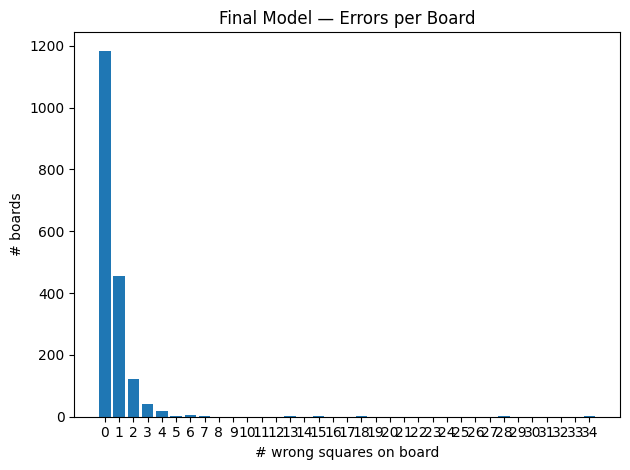

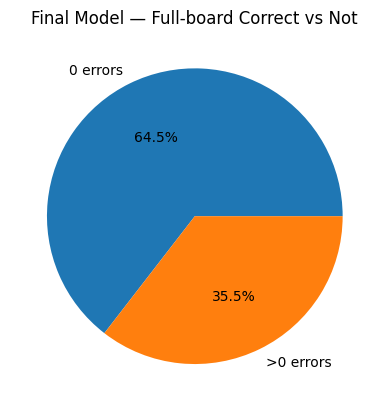

In [ ]:
# (Optional) If you want to parse the raw epoch-31 text directly, use this instead:

import re
import numpy as np
import matplotlib.pyplot as plt

raw = """
Boards with  0 wrong squares: 1184
Boards with  1 wrong squares: 454
Boards with  2 wrong squares: 123
Boards with  3 wrong squares: 42
Boards with  4 wrong squares: 17
Boards with  5 wrong squares: 3
Boards with  6 wrong squares: 6
Boards with  7 wrong squares: 1
Boards with 13 wrong squares: 1
Boards with 15 wrong squares: 1
Boards with 18 wrong squares: 1
Boards with 28 wrong squares: 1
Boards with 34 wrong squares: 1
""".strip()

pairs = re.findall(r"Boards with\s+(\d+)\s+wrong squares:\s+(\d+)", raw)
error_counts = {int(k): int(v) for k, v in pairs}

max_err = max(error_counts.keys())
errs = np.arange(0, max_err + 1)
counts = np.array([error_counts.get(e, 0) for e in errs])

total_boards = counts.sum()
zero_ok = error_counts.get(0, 0)
nonzero = total_boards - zero_ok

print(f"Final Model — total boards: {total_boards}")
print(f"0-error boards: {zero_ok}")
print(f">0-error boards: {nonzero}")

plt.figure()
plt.bar(errs, counts, width=0.8)
plt.title("Final Model — Errors per Board")
plt.xlabel("# wrong squares on board")
plt.ylabel("# boards")
plt.xticks(errs)
plt.tight_layout()
plt.show()

plt.figure()
plt.pie([zero_ok, nonzero], labels=["0 errors", ">0 errors"], autopct="%1.1f%%")
plt.title("Final Model — Full-board Correct vs Not")
plt.show()
